This notebook is used to test the range of litterature values of copepod material properties and their effects of the modeled target spectra.

In [3]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy import signal
from scipy import optimize
from scipy import linalg
from scipy.interpolate import UnivariateSpline
from scipy import stats as st
import matplotlib as mpl
import matplotlib.pyplot as plt
import array as arr
import seaborn as sns
import random
import pylab
import glob
from scipy import stats
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import datetime

import inverse_method_funs_med as inv

In [4]:
sns.set_theme(style="whitegrid")
sns.color_palette("viridis", as_cmap=True)
title_font = {
    'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black',
    'weight': 'medium'
}
axis_font = {'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black'}


plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams['font.size']= 15

mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize'] = 16

savefigs_path = 'C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AZKABAN-light/ZoopMix_paper/'

# Read results from scattering models
Scattering models for the copepods, krill and chaetognaths in the nets were run in ZooScatR, a package that runs PC-DWBA.

In [8]:
fname_sim = '../ZooScatStuff/AZKABAN_ZoopMix_Copepodtests.feather'
simulations = pd.read_feather(fname_sim)
# Add a row for sigma_bs calculated from TS
simulations['sigbs'] = 10**(simulations.TS/10)

In [9]:
specs = simulations.spec.unique()
freqs = simulations.freq.unique()

# Calculate ci

In [10]:
def ci0(x):
    return  st.t.interval(0.50, len(x) - 1, scale=st.sem(x, nan_policy='omit'))[0]
def ci1(x):
    return  st.t.interval(0.50, len(x) - 1, scale=st.sem(x, nan_policy='omit'))[1]

ci_0 = simulations.groupby(["spec","freq"]).agg({'sigbs': ci0})
ci_1 = simulations.groupby(["spec","freq"]).agg({'sigbs': ci1})

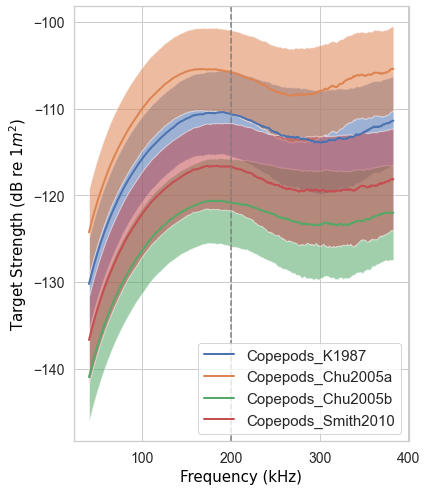

In [24]:
# Convert to log confidence intervals
simulations_median = simulations.groupby(["spec","freq"]).agg({'sigbs':'median'})
median_bs = simulations_median.reset_index('freq')

fig, ax = plt.subplots(figsize=(6, 8),facecolor='w', edgecolor='k')
order = [0,1,2,3]
label_name=specs
for ind in order:

    median_select = median_bs.loc[specs[ind]]['sigbs'].to_numpy()
    ci_0_select = ci_0.loc[specs[ind]]['sigbs'].to_numpy()
    ci_1_select = ci_1.loc[specs[ind]]['sigbs'].to_numpy()
    
    # Calculate log ci S(TS) = 10*0.434(S(sigbs)/sigbs)
    logci_0 = 10*np.log10(median_select) - (10*(0.434*(median_select-ci_0_select)/median_select))
    logci_1 = 10*np.log10(median_select) + (10*(0.434*(median_select+ci_1_select)/median_select))
    
    plt.plot(freqs,10*np.log10(median_select), linewidth=2, label=label_name[ind])
    plt.fill_between(freqs,logci_0, logci_1, alpha=0.55)
    
#plt.legend(fontsize=15, loc=(0.40,0.25))
plt.legend(fontsize=15, loc='lower right')
plt.ylabel('Target Strength (dB re $1m^{2}$)', axis_font)
plt.xlabel('Frequency (kHz)', axis_font)
plt.axvline(x=200, linestyle='--', c='grey')

#plt.title('Scattering model results', title_font);

ax.set_rasterized(True)
fig.savefig('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AZKABAN-light/ZoopMix_paper/copepodtest_all.pdf', format='pdf', dpi = 300, facecolor='w', bbox_inches='tight')
#fig.savefig(savefigjpg_path+'Figure6.jpg', format='jpg', dpi = 300, facecolor='w', bbox_inches='tight')

As expected the shaps of the target spectra is consistent across the different simulations because it is mainly determine by shape parameters (shape file, length and widths) and the differences in material properties (g and h) change the magnitude of the curve.

The values from Chu and Wiebe 2005 from May 2nd represent copepods with the strongest backscatters. These values are g=0.996 and h=1.012. Similar to Kogeler 1987 but a h close to unity. The Chu and Wiebe (2005) values are for Calanus of similar size (3mm) and in a similar environment (T=-1 to 2 deg C).

Which species of Calanus are found in Antarctica? Can we use these values instead? We find very few target detections below -105 dB, maybe our inital g and h values (from Kogeler et al. 1987, chosen because of the "proximity" to our sample location) were resulting in a modeled magnitude too low.

In [16]:
# Print mean TS
for spec_ind in range(len(specs)):
    TS_mean = 10*np.log10(np.mean(median_bs[median_bs.index==specs[spec_ind]].sigbs))
    print(f'Mean TS for {specs[spec_ind]} is {TS_mean:.2f} dB re 1m^2.')

Mean TS for Copepods_K1987 is -112.88 dB re 1m^2.
Mean TS for Copepods_Chu2005a is -107.42 dB re 1m^2.
Mean TS for Copepods_Chu2005b is -122.96 dB re 1m^2.
Mean TS for Copepods_Smith2010 is -119.07 dB re 1m^2.


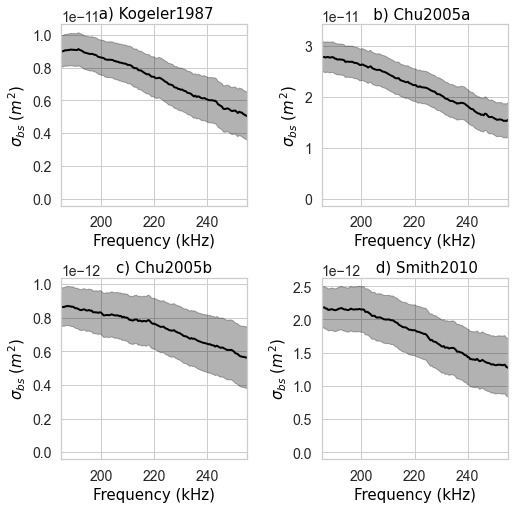

In [21]:
def ci0_linear(x):
    return  st.t.interval(0.50, len(x) - 1, loc=np.nanmedian(x), scale=st.sem(x, nan_policy='omit'))[0]
def ci1_linear(x):
    return  st.t.interval(0.50, len(x) - 1, loc=np.nanmedian(x), scale=st.sem(x, nan_policy='omit'))[1]

ci_0_linear = simulations.groupby(["spec","freq"]).agg({'sigbs': ci0_linear})
ci_1_linear = simulations.groupby(["spec","freq"]).agg({'sigbs': ci1_linear})

# Convert to log confidence intervals
simulations_median = simulations.groupby(["spec","freq"]).agg({'sigbs':'median'})
median_bs = simulations_median.reset_index('freq')

fig, ax = plt.subplots(2,2, figsize=(8, 8),facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=.4, wspace=0.4)
axes = ax.flatten()
order = [0,1,2,3]
letter = [' a) Kogeler1987','   b) Chu2005a', '    c) Chu2005b', '     d) Smith2010']
for i in range(4):
    ind = order[i]
    median_select = median_bs.loc[specs[ind]]['sigbs'].to_numpy()
    ci_0_select = ci_0_linear.loc[specs[ind]]['sigbs'].to_numpy()
    ci_1_select = ci_1_linear.loc[specs[ind]]['sigbs'].to_numpy()

    
    axes[i].plot(freqs,median_select, color='black', linewidth=2)#, color=sns.color_palette()[i])
    axes[i].fill_between(freqs,ci_0_select, ci_1_select, color='black', alpha=0.3)#, color=sns.color_palette()[i])
    
    axes[i].set_title(letter[i], title_font)
    axes[i].set_ylabel('$\sigma_{bs}$ ($m^{2}$)', axis_font)
    axes[i].set_xlabel('Frequency (kHz)', axis_font)
    #plt.axvline(x=200, linestyle='--', c='grey')
    axes[i].set_xlim([185,255])
    axes[i].set_rasterized(True)
    


#plt.title('Scattering model results', title_font);


#fig.savefig(savefigs_path+'Figure6.pdf', format='pdf', dpi = 300, facecolor='w', bbox_inches='tight')
fig.savefig('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AZKABAN-light/ZoopMix_paper/copepodtest_linear.jpg', format='jpg', dpi = 300, facecolor='w', bbox_inches='tight')

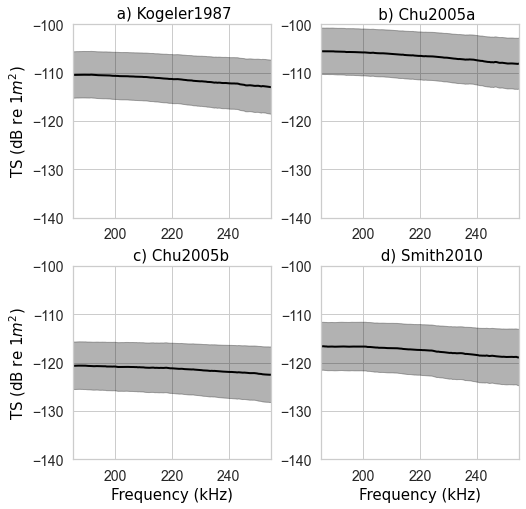

In [26]:
def ci0_linear(x):
    return  st.t.interval(0.50, len(x) - 1, loc=np.nanmedian(x), scale=st.sem(x, nan_policy='omit'))[0]
def ci1_linear(x):
    return  st.t.interval(0.50, len(x) - 1, loc=np.nanmedian(x), scale=st.sem(x, nan_policy='omit'))[1]

ci_0_linear = simulations.groupby(["spec","freq"]).agg({'sigbs': ci0_linear})
ci_1_linear = simulations.groupby(["spec","freq"]).agg({'sigbs': ci1_linear})

# Convert to log confidence intervals
simulations_median = simulations.groupby(["spec","freq"]).agg({'sigbs':'median'})
median_bs = simulations_median.reset_index('freq')

fig, ax = plt.subplots(2,2, figsize=(8, 8),facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=.25, wspace=0.25)
axes = ax.flatten()
order = [0,1,2,3]
letter = [' a) Kogeler1987','   b) Chu2005a', '    c) Chu2005b', '     d) Smith2010']
for i in order:
    median_select = median_bs.loc[specs[i]]['sigbs'].to_numpy()
    ci_0_select = ci_0.loc[specs[i]]['sigbs'].to_numpy()
    ci_1_select = ci_1.loc[specs[i]]['sigbs'].to_numpy()
    
    # Calculate log ci S(TS) = 10*0.434(S(sigbs)/sigbs)
    logci_0 = 10*np.log10(median_select) - (10*(0.434*(median_select-ci_0_select)/median_select))
    logci_1 = 10*np.log10(median_select) + (10*(0.434*(median_select+ci_1_select)/median_select))
    
    axes[i].plot(freqs,10*np.log10(median_select), color='black', linewidth=2, label=label_name[i])
    axes[i].fill_between(freqs,logci_0, logci_1, color='black', alpha=0.3)
    axes[i].set_title(letter[i], title_font)


    #plt.axvline(x=200, linestyle='--', c='grey')
    axes[i].set_ylim([-140,-100])
    axes[i].set_xlim([185,255])
    axes[i].set_rasterized(True)

axes[0].set_ylabel('TS (dB re $1m^{2}$)', axis_font)
axes[2].set_ylabel('TS (dB re $1m^{2}$)', axis_font)

axes[2].set_xlabel('Frequency (kHz)', axis_font)
axes[3].set_xlabel('Frequency (kHz)', axis_font)

#plt.title('Scattering model results', title_font);


#fig.savefig(savefigs_path+'Figure6.pdf', format='pdf', dpi = 300, facecolor='w', bbox_inches='tight')
fig.savefig(savefigs_path +'copepodtest.jpg', format='jpg', dpi = 300, facecolor='w', bbox_inches='tight')